# Evaluation of applications
Test if all MSAs are available and of proper size. Load the first cell before executing another cell!

In [1]:
import pandas as pd
# Global parameters
PATH_SUFFIX = "_Validation_Set"
# PATH_SUFFIX = ""
CSV_FILE = f"MolToFam{PATH_SUFFIX}.csv"

Several tests:

In [2]:
import pandas as pd
import os

df = pd.read_csv(CSV_FILE)

# Test if there is an MSA
for e in df.iloc:
    if not os.path.isfile(f"MSA{PATH_SUFFIX}/{e.Family}.faclean"):
        print(f"Missing file for {e.PDB}. Reload Family {e.Family}")
# Test if there are not too many
remove_string = "rm"
for f in os.listdir(f"MSA{PATH_SUFFIX}"):
    if not f.replace(".faclean", "") in list(df["Family"]):
        remove_string = " ".join([remove_string, f]) 
        print(f"Family file {f} is not in DB.")
print(remove_string)
# Test if size is in accordance to database
for e in df.iloc:
    with open(f"MSA{PATH_SUFFIX}/{e.Family}.faclean") as f:
        snd_line = f.read().splitlines()[1]
    if len(snd_line) != e.L:
        print(f"Mismatch of {e.PDB}: {len(snd_line)} should be {e.L}")

rm


## Preparation
### 1. DCA 
We use mfDCA as it is implemented in pyDCA and the MSA files given in `MSA_Validation_Set`

#### 1.1 Creating Restraint files
**Important:** Use here a Kernel with a working pyDCA package!

In [3]:
import pandas as pd
from pydca.meanfield_dca import meanfield_dca
from pydca.msa_trimmer import msa_trimmer

df = pd.read_csv(CSV_FILE)

for e in df.iloc:
    out_file = f"MSA{PATH_SUFFIX}/{e.Family}_trimmed.fa"
    trimmer = msa_trimmer.MSATrimmer(f"MSA{PATH_SUFFIX}/{e.Family}.faclean", biomolecule='rna', refseq_file=f"Sequence{PATH_SUFFIX}/{e.Filename}.fa")
    trimmed_data = trimmer.get_msa_trimmed_by_refseq(remove_all_gaps=True)
    with open(out_file, 'w') as file:
        for seqid, seq in trimmed_data:
            file.write('>{}\n{}\n'.format(seqid, seq))

    #create mean-field DCA instance 
    mfdca_inst = meanfield_dca.MeanFieldDCA(
        out_file,
        'rna',
        pseudocount = 0.5,
        seqid = 0.8,

    )

    # Compute average product corrected Frobenius norm of the couplings
    mfdca_FN_APC = mfdca_inst.compute_sorted_FN_APC()
    #Write out
    scores_out = f"Restraints{PATH_SUFFIX}/DCA/{e.Family}_raw.txt"

    with open(scores_out, 'w') as file:
        file.write(f"i, j, score\n")
        for site_pair, score in mfdca_FN_APC:
            file.write(f"{site_pair[0]},{site_pair[1]},{score}\n")


### 2. CoCoNet
All initial contact data from the original publication from Zerihun et al.

In [ ]:
import os 
import pandas as pd

df = pd.read_csv(CSV_FILE)
for e in df.iloc:
    if not os.path.isfile(f"Restraints{PATH_SUFFIX}/COCONET/COCONET3x3_{e.Family}.txt"):
        print(f"Family file {e.Family} cannot be found.")

for e in os.listdir(f"Restraints{PATH_SUFFIX}/COCONET/"):
    if not (df["Family"] == e[11:-4]).any():
        print(e)

### 3. Barnacle

In [ ]:
import numpy as np

test = np.load("barnacle_results/vanilla_barnacle/RF01857.npy")

## Analysis
Calculate all the PPVs, Gauss Scores and RMSDs for the Validation Set.

In [ ]:
import pandas as pd
from BioHelpers_FABER.cmap import Cmap
from BioHelpers_FABER.visualisation import show_contact_map
import BioHelpers_FABER.rmsd as rmsd
import os.path
import ast
import warnings
warnings.filterwarnings("ignore")

noc_fac = 0.5 
df = pd.read_csv(CSV_FILE, comment='#')

# Calculate PPV and Gauss

ppv_dca = []
ppv_coconet = []
ppv_barnacle = []
gauss_dca = []
gauss_coconet = []
gauss_barnacle = []
for e in df.iloc:
    cm = Cmap()
    cm.load_native_pdb(f"PDB{PATH_SUFFIX}/{e.Filename}.pdb", e.PDB, reference="nearest", contact_threshold=10., start_from_one=e.From_One, added_tail=e.Add_Tail)
    print(cm.pdb_id)
    cm.load_contacts_from_restraints(f"Restraints{PATH_SUFFIX}/DCA/simrna_{e.Filename}_L{noc_fac}.res", "DCA")
    cm.load_contacts_from_restraints(f"Restraints{PATH_SUFFIX}/COCONET/simrna_{e.Filename}_L{noc_fac}.res", "COCONET")
    cm.load_contacts_from_restraints(f"Restraints{PATH_SUFFIX}/BARNACLE_VANILLA/simrna_{e.Filename}_L{noc_fac}.res", "BARNACLE")
    fig,ax = show_contact_map(cm, ["DCA", "COCONET", "BARNACLE"], mark_match=True)
    fig.savefig(f"Plots/cm_{cm.pdb_id}.png")
    ppv_dca.append(cm.ppvs["DCA"])
    ppv_coconet.append(cm.ppvs["COCONET"])
    ppv_barnacle.append(cm.ppvs["BARNACLE"])
    gauss_dca.append(cm.gauss["DCA"])
    gauss_coconet.append(cm.gauss["COCONET"])
    gauss_barnacle.append(cm.gauss["BARNACLE"])

df["PPV_DCA"] = ppv_dca
df["PPV_COCONET"] = ppv_coconet
df["PPV_BARNACLE"] = ppv_barnacle
df["GAUSS_DCA"] = gauss_dca
df["GAUSS_COCONET"] = gauss_coconet
df["GAUSS_BARNACLE"] = gauss_barnacle

# Calculate RMSD

methods = ["barnacle", "coconet", "dca"]
values = {m:[] for m in methods}
for i, row in df.iterrows():
    for m in methods:
        file1 = f"PDB_results/{row.PDB}_{m}.pdb"
        file2 = f"PDB_Validation_Set/cleaned/{row.PDB}_rpr.pdb"
        if os.path.isfile(file1) and os.path.isfile(file2):
            t = ast.literal_eval(row.Unmodelled_Regions)
            values[m].append(rmsd.rmsd_pdb(file1, file2, exclude_residues=t))
        else:
            print(f"File not found for {row.PDB}_{m}.pdb")
df["RMSD_DCA"] = values["dca"]
df["RMSD_COCONET"] = values["coconet"]
df["RMSD_BARNACLE"] = values["barnacle"]


Save dataframe:

In [3]:
df.to_csv(f"results{PATH_SUFFIX}.csv", index=False)

Load dataframe:

In [2]:
df = pd.read_csv(f"results{PATH_SUFFIX}.csv")
df["GAUSS_L_DCA"] = df["GAUSS_DCA"]/df["L"]
df["GAUSS_L_COCONET"] = df["GAUSS_COCONET"]/df["L"]
df["GAUSS_L_BARNACLE"] = df["GAUSS_BARNACLE"]/df["L"]

#Drop specific values where PPV is too low
df = df.drop(9).drop(13).drop(16).drop(8)

Create figure for publication:

In [3]:
from BioHelpers_FABER.cmap import Cmap
cm = Cmap()
cm.load_native_pdb(f"PDB{PATH_SUFFIX}/6ues.pdb","6ues", reference="nearest")
cm.load_contacts_from_restraints(f"Restraints{PATH_SUFFIX}/DCA/simrna_6ues_L0.5.res", "DCA")
cm.load_contacts_from_restraints(f"Restraints{PATH_SUFFIX}/COCONET/simrna_6ues_L0.5.res", "COCONET")
cm.load_contacts_from_restraints(f"Restraints{PATH_SUFFIX}/BARNACLE_VANILLA/simrna_6ues_L0.5.res", "BARNACLE")

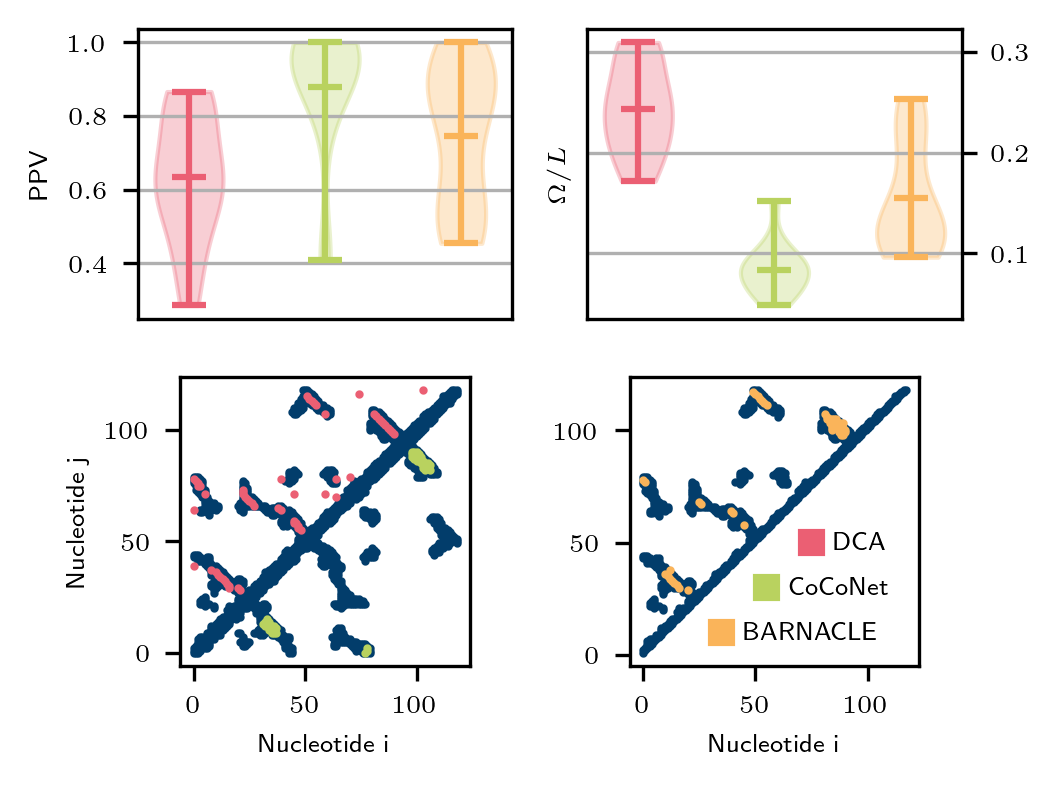

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rcParams.update({'font.size': 6})
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'figure.dpi':300})

cmtoinch = 0.3937

fig, axs = plt.subplots(2, 2, figsize=(9*cmtoinch, 7*cmtoinch))
face_color_plot=["#eb5f73", "#b9d25f", "#fab45a", "#023d6b"]
means_color_plot = face_color_plot
plots = []
plots.append(axs[0,0].violinplot([df["PPV_DCA"], df["PPV_COCONET"], df["PPV_BARNACLE"]], showmeans=True))
plots.append(axs[0,1].violinplot([df["GAUSS_DCA"]/df["L"], df["GAUSS_COCONET"]/df["L"], df["GAUSS_BARNACLE"]/df["L"]], showmeans=True))
axs[1,0].scatter(cm.native_contacts.nonzero()[0], cm.native_contacts.nonzero()[1], s=1, c=face_color_plot[3])
axs[1,0].scatter(cm.contacts["DCA"].nonzero()[0], cm.contacts["DCA"].nonzero()[1], s=1, c=means_color_plot[0])
axs[1,0].scatter(cm.contacts["COCONET"].nonzero()[1], cm.contacts["COCONET"].nonzero()[0],s=1, c=means_color_plot[1])
axs[1,0].set_aspect("equal")
axs[1,1].scatter([y for x,y in zip(*cm.native_contacts.nonzero()) if x>y], [x for x,y in zip(*cm.native_contacts.nonzero()) if x>y], s=1, c=face_color_plot[3])
axs[1,1].scatter(cm.contacts["BARNACLE"].nonzero()[0], cm.contacts["BARNACLE"].nonzero()[1], s=1, c=means_color_plot[2])

axs[1,1].set_aspect("equal")
axs[1,1].text(85, 47, "DCA ")
axs[1,1].text(65, 27, "CoCoNet ")
axs[1,1].text(45, 7, "BARNACLE ")

axs[1,1].add_patch(patches.Rectangle((30,5), 10, 10, color=means_color_plot[2]))
axs[1,1].add_patch(patches.Rectangle((50,25), 10, 10, color=means_color_plot[1]))
axs[1,1].add_patch(patches.Rectangle((70,45), 10, 10, color=means_color_plot[0]))
axs[0,0].set_xticks([])
axs[0,1].set_xticks([])
axs[0,1].yaxis.tick_right()
axs[0,0].set_ylabel(r"PPV")
axs[0,1].set_ylabel(r"$\Omega/L$")
axs[1,0].set_ylabel(r"Nucleotide j")
axs[1,0].set_xlabel(r"Nucleotide i")
axs[1,1].set_ylabel("")
axs[1,1].set_xlabel(r"Nucleotide i")
axs[0,0].yaxis.grid(zorder=-1)
axs[0,1].yaxis.grid(zorder=-1)



for plot in plots:
    for c,vp in zip(face_color_plot, plot["bodies"]):
        vp.set_facecolor(c)
        vp.set_edgecolor(c)
    for partname in ('cbars','cmins','cmaxes','cmeans'):
        plot[partname].set_color(means_color_plot)


#plt.savefig("application.png", transparent=True, dpi=300)
plt.show()

Look at a specific contact map:

Restraints_Validation_Set/DCA/simrna_6ues_L0.5.res
PDB_Validation_Set/6ues.pdb


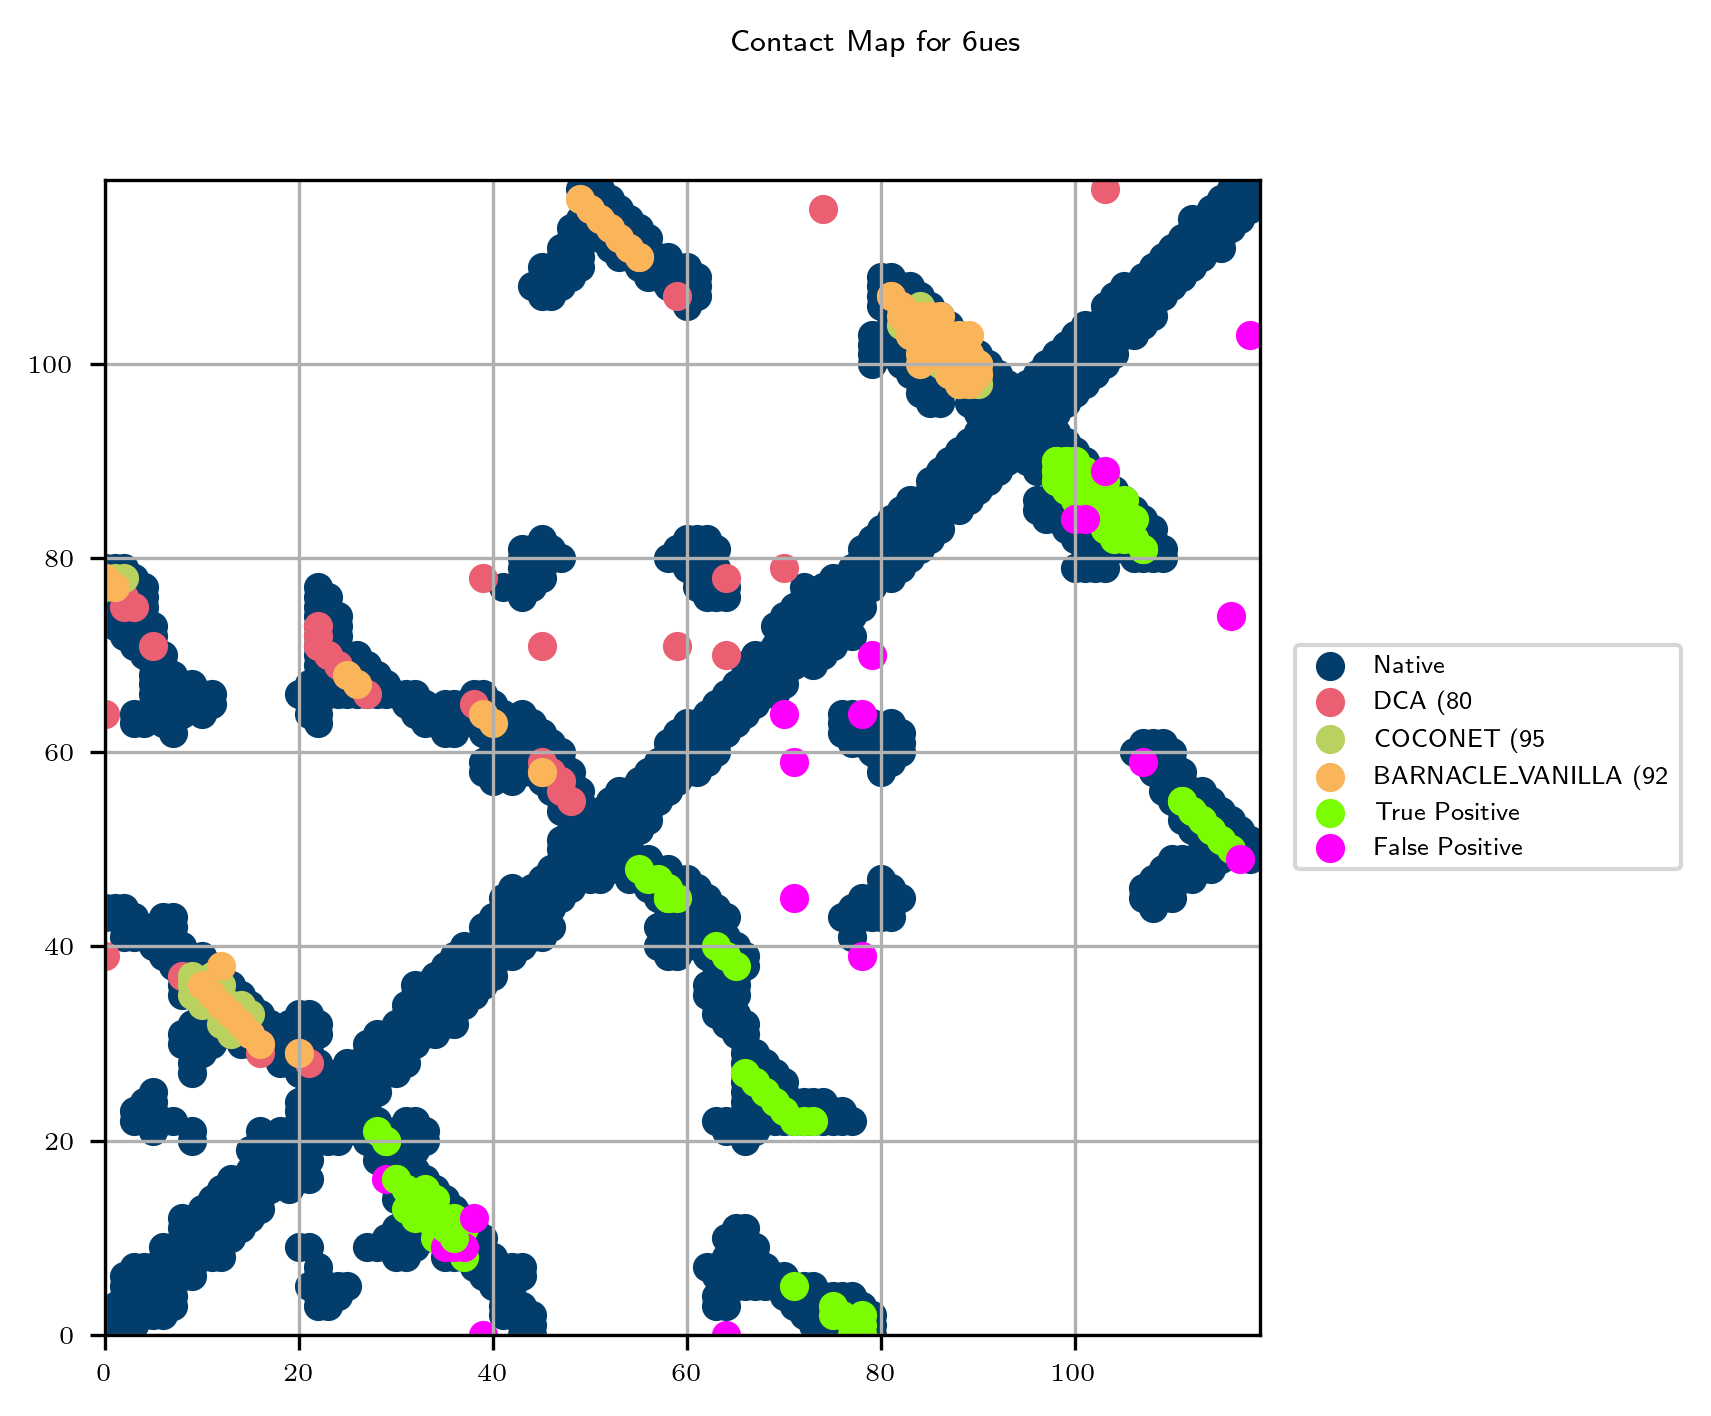

In [24]:
from BioHelpers_FABER.cmap import Cmap
from BioHelpers_FABER.visualisation import show_contact_map
from BioHelpers_FABER.bio_mod import arr_to_contact_list
import pandas as pd
import copy
import matplotlib.pyplot as plt

noc_fac= 0.5 

def load_contact_map(pdb_name: str, noc_fac: float = 1.0, start_from_one: bool = True) -> Cmap:
    df_names = pd.read_csv(CSV_FILE)
    cm = Cmap()
    print(f"Restraints{PATH_SUFFIX}/DCA/simrna_{df_names[df_names['PDB']==pdb_name].Filename.values[0]}_L{noc_fac}.res")
    print(f"PDB{PATH_SUFFIX}/{df_names[df_names['PDB']==pdb_name].Filename.values[0]}.pdb")
    cm.load_native_pdb(f"PDB{PATH_SUFFIX}/{df_names[df_names['PDB']==pdb_name].Filename.values[0]}.pdb", pdb_name, reference="nearest",start_from_one=start_from_one)
    cm.load_contacts_from_restraints(f"Restraints{PATH_SUFFIX}/DCA/simrna_{df_names[df_names['PDB']==pdb_name].Filename.values[0]}_L{noc_fac}.res", "DCA")
    cm.load_contacts_from_restraints(f"Restraints{PATH_SUFFIX}/COCONET/simrna_{df_names[df_names['PDB']==pdb_name].Filename.values[0]}_L{noc_fac}.res", "COCONET")
    cm.load_contacts_from_restraints(f"Restraints{PATH_SUFFIX}/BARNACLE_VANILLA/simrna_{df_names[df_names['PDB']==pdb_name].Filename.values[0]}_L{noc_fac}.res", "BARNACLE_VANILLA")
    cm.load_contacts_from_restraints(f"Restraints{PATH_SUFFIX}/BARNACLE_GAUSS/simrna_{df_names[df_names['PDB']==pdb_name].Filename.values[0]}_L{noc_fac}.res", "BARNACLE_GAUSS")
    return cm

# cm_1c2x = load_contact_map("1c2x", noc_fac)
# cm_6qn3 = load_contact_map("6qn3", noc_fac)
contact_map = load_contact_map("6ues", noc_fac)


#cm_1ehz.show_contact_map(["DCA", "COCONET"], mark_match=True)
#load_contact_map("1ehz", noc_fac=noc_fac).show_contact_map(["COCONET"], mark_match=True)
fig, ax = show_contact_map(contact_map, ["DCA", "COCONET","BARNACLE_VANILLA"], mark_match=True)
plt.show()

Calculate correlations: